In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk


C:\Users\35385\AppData\Local\Temp\ipykernel_18268\4027385126.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval=interval, period=PERIOD)
[*********************100%***********************]  1 of 1 completed

Coefficient: [-0.05219767]
Intercept: 4.156894705134256
0.007478168309215105


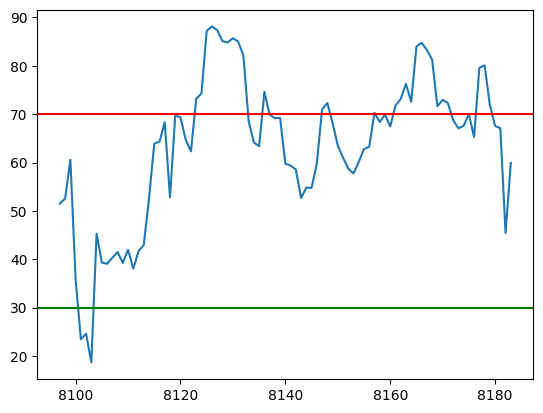

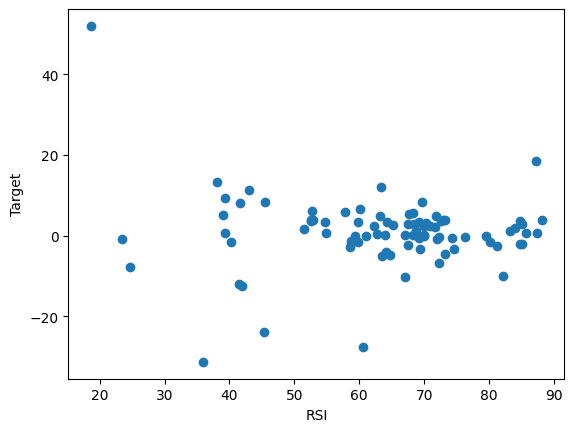

In [ ]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'


# target variable, shifted version of close price
# say want to see how indicator is related to close price change, tomorrow
# shift one day test correlation of price change one day from now
# e.g. would want negative correlation with value of  RSI and close price change following day cause higher the value the RSI index the more overbought a price is denoted to be
SHIFT = 1
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 100

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]



# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):
    
    #Close price, shift days from now in current row
    df[f'Close + {shift}'] = df['Close'].shift(-shift)
    #what is the change in close price SHIFT days from now
    df['Target'] = df[f'Close + {shift}'] - df['Close']

    #Note; is there a correlation between close and target, using RSI to see if there's a negative correlation
    return df



    
#take RSI code to be feature
def add_RSI(df, length = RSI_LENGTH):
    
    #delta is change in price, diff shows diff between given row

    price_change = df['Close'].diff()

    #seperate gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change<0,0)

    #average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #what % of each have the gains and losses been (RSI)
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red') # # above red: overbought, potential short
    plt.axhline(OVERSOLD, color = 'green') # # below green: oversold, potential long

    return df.dropna()


def generate_regression_output(df, features='RSI', target='Target'):
    #R squared, correlation coeff & intercept

    subset = df[[features,target]].dropna()

    #reshapre for sklearn
    X = subset[[features]].values #2d
    y = subset[target].values #1d, why always 1d

    model = sk.linear_model.LinearRegression()
    model.fit(X,y)


    # use regression model to "predict" the target variable
    y_pred = model.predict(X)

    # what is the relationship between x & y
    r2 = sk.metrics.r2_score(y,y_pred)

    # coef, intercept, r2
    print(f"Coefficient: {model.coef_}") 
    print(f"Intercept: {model.intercept_}")
    print(r2)

    # plot a relationship between feature and target
    plt.figure()
    plt.scatter(X,y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")


    return





def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    df = generate_regression_output(df)
    return df

df = main()
df